In [1]:
import tensorflow as tf
import random
from numba import jit
import os
import csv
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import matplotlib.image as mpimg

# Compétition Kaggle : Image segmentation pour la production d'acier

# Load to memory

### PATHS and DIRECTORIES

In [2]:
# get local variables
local_path = os.getcwd()
data_path = os.path.join(local_path,'data/')

# data directories
train_dir = os.path.join(data_path,'train_images/')
validation_dir = os.path.join(data_path,'validation_images/')

# csv files 
train_csv = os.path.join(data_path,'train.csv')
validation_csv = os.path.join(data_path,'validation.csv')

# mask directories
masks_train_dir = os.path.join(data_path,'train_masks/')
masks_validation_dir = os.path.join(data_path,'validation_masks/')

### Fonctions de conversion

In [3]:
from preprocessing import *

### Load descrition dictionnaries to memory

In [21]:
# On créer les dictionnaires importants
train_descriptions = CSV_to_descriptions(train_csv)
validation_descriptions = CSV_to_descriptions(validation_csv)

### Example

ef24da2ba
3.0


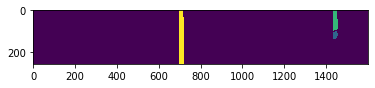

(256, 1600, 3)


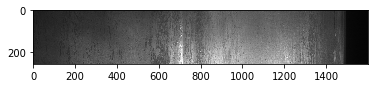

In [5]:
##plot random images with their segmentations

# select random image
img_number = random.randint(0,len(train_descriptions.keys())-1)
img_name = list(train_descriptions.keys())[img_number]
img_name = 'ef24da2ba'
print(img_name)
#img = mpimg.imread(os.path.join(TRAINING_DIR,img_name))
#plot image
description_to_image(img_name,train_descriptions,train_dir,True)

Un rapide calcul nous montre qu'il est impossible de charger en mémoire toutes les images. En effet, bien qu'elles soient toutes compréssée pour tenir dans 2.5Go, les outputs, mêmes codés en 8 bits, prendraient 15 Go de mémoire vive. On va donc se contenter de créer une fonction qui retourne un vecteur avec un mask. 


## Final fonction

In [6]:
def image_to_mask(description_dict, img_name):
    return description_to_image(img_name,description_dict)

In [22]:
image_to_mask(train_descriptions,'9aa721852').shape

(256, 1600)

# Preprocessing

On commence par une première version simplifiée. On va réduire les data_sets pour réduire le poids en mémoire. De plus on va uniquement programmer en CPU. Les améliorations se succèderont ensuite. 
Images : $256\times1600\times3$


In [7]:
#(x_train, y_train), (x_test, y_test) = load_data()
def load_data(number_images, descriptions_dict,):
    "rentre en mémoire les images et les sorties"
    
    train_size = int(number_images*0.8)
    test_size = int(number_images*0.2)
    
    # get image directory
    image_directory = join(os.getcwd(),'data','train_images/')
    
    # output
    compteur = 0
    train_mask_list = []
    test_mask_list = []
    train_image_list = []
    test_image_list = []
    train_img_name_list = list(descriptions_dict.keys())
    
    # taking random pictures
    while compteur < train_size:
        img_name = train_img_name_list.pop(random.randint(0,len(train_img_name_list)-1))
        train_image_list.append(mpimg.imread(os.path.join(image_directory,img_name+'.jpg')))
        train_mask_list.append(image_to_mask(descriptions_dict,img_name))
        compteur+=1
    
    # filling test dictionnary
    while compteur < number_images:
        img_name = train_img_name_list.pop(random.randint(0,len(train_img_name_list)-1))
        test_image_list.append(mpimg.imread(os.path.join(image_directory,img_name+'.jpg')))
        test_mask_list.append(image_to_mask(descriptions_dict,img_name))
        compteur+=1
    
    return (np.array(train_image_list,dtype = np.half)
            ,np.expand_dims(np.array(train_mask_list,dtype = np.half),axis = -1)),(
        np.array(test_image_list,dtype = np.half),
        np.expand_dims(np.array(test_mask_list,dtype = np.half),axis = -1))

In [8]:
(x_train, y_train), (x_test, y_test) = load_data(50,train_descriptions)

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)

In [10]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(10000).batch(32)

In [11]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 1600, 3), dtype=tf.float16, name=None),
 TensorSpec(shape=(None, 256, 1600, 1), dtype=tf.float16, name=None))

# Création du modèle

In [12]:
class MyModel(tf.keras.Model):
    def __init__(self,):
        super(MyModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(5,(9,9),padding="same",activation = "relu")

    def call(self, x):
        return self.conv1(x)

# Create an instance of the model
model = MyModel()

Choose an optimiser and a loss function

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [14]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [15]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [16]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [17]:
EPOCHS = 5

for epoch in range(EPOCHS):
# Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 94.36366271972656, Accuracy: 1.611230492591858, Test Loss: 63.6428337097168, Test Accuracy: 3.0377197265625
Epoch 2, Loss: 61.62761306762695, Accuracy: 2.9416139125823975, Test Loss: 22.07131576538086, Test Accuracy: 7.813257217407227
Epoch 3, Loss: 14.213418006896973, Accuracy: 20.737041473388672, Test Loss: 1.5389795303344727, Test Accuracy: 92.37202453613281
Epoch 4, Loss: 2.1153016090393066, Accuracy: 93.57147979736328, Test Loss: 1.5805014371871948, Test Accuracy: 95.2242431640625
Ep

In [18]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1220      
Total params: 1,220
Trainable params: 1,220
Non-trainable params: 0
_________________________________________________________________


# Post Processing

In [19]:
# we will predict this image

image_directory = join(os.getcwd(),'data','train_images/')
input_image_name = 'ef24da2ba'
input_image = image_to_mask(train_descriptions,input_image_name)
input_image = mpimg.imread(os.path.join(image_directory,input_image_name+'.jpg'))
input_image = np.expand_dims(input_image,axis = 0)
input_image = np.array(input_image,dtype = np.float32)
pred = model.call(input_image)

pred.shape
pred[0].shape
pred[0,:,:,1].shape


TensorShape([256, 1600])

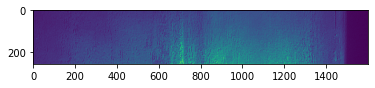

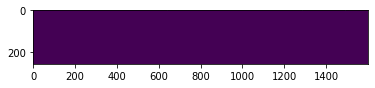

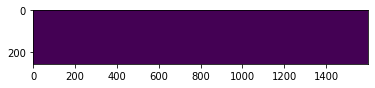

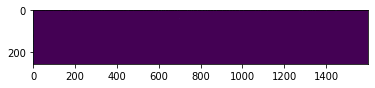

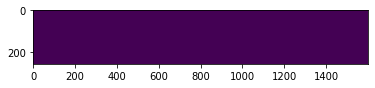

In [20]:
for i in range(5):
    plt.imshow(pred[0,:,:,i]*10000)
    plt.show()